In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
# %pdb

import os
from IPython.core.debugger import set_trace

from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import time
import scipy.stats

import h5py
from scipy.ndimage.filters import gaussian_filter1d


import cosmos.traces.trace_analysis_utils as utils
from cosmos.behavior.bpod_dataset import BpodDataset
import cosmos.imaging.atlas_registration as reg
from cosmos.traces.cell_plotter import CellPlotter
from cosmos.traces.cosmos_traces import CosmosTraces

import cosmos.params.trace_analyze_params as params ### All variables here should be capitalized.

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
# Select dataset.
# base_path = '/home/izkula/Data/processedData/'
data_dir = '/home/izkula/Dropbox/cosmos_data/'
fig_save_dir = '/home/izkula/Dropbox/cosmos/trace_analysis/'
bpod_dir = '/home/izkula/Dropbox/cosmos_data/behavior/'

dataset_id = 7 #11
dataset = params.DATASETS[dataset_id]
print(dataset)
dataset['data_root'] = data_dir
dataset['fig_save_dir'] = fig_save_dir
dataset['behavior_dir'] = bpod_dir

{'info': '***Imported this 4/2/18. Very good behavior.', 'name': 'cux2ai148m72_COSMOSTrainMultiBlockGNG_1', 'date': '20180401', 'bpod_file': 'cux2m72/COSMOSTrainMultiBlockGNG/Session Data/cux2m72_COSMOSTrainMultiBlockGNG_20180401_134852.mat', 'ttl_file': 'cux2m72-20180401-134904-TTL.pkl'}


(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:211
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
Saving to:  /home/izkula/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_pre-reward.pdf
Saving to:  /home/izkula/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_post-reward.pdf
Saving to:  /home/izkula/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/licks.pdf
Saving to:  /home/izkula/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/success_rate.pdf
(3/3) Loading TTL data.
Dev1/ai4 behavior_upper 0.005 s, 200.0 Hz
Dev1/ai0 imaging 0.034 s, 29.369 Hz
Dev1/ai3 visual_stimulus 24.438 s, 0.041 Hz
Dev1/ai2 trials 10.948 s, 0.091 Hz
Dev1/ai1 behavior_lower 0.005 s, 200.0 Hz
LED trials: 212
TTL trials: 213 Bpod trials: 211
Processing traces.
[  7. 394.

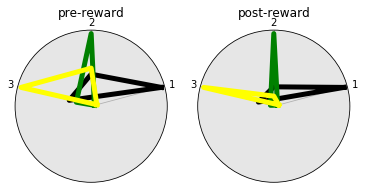

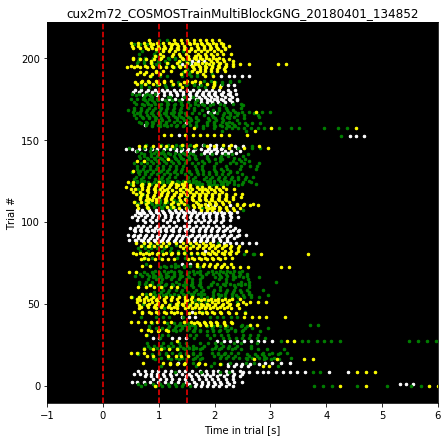

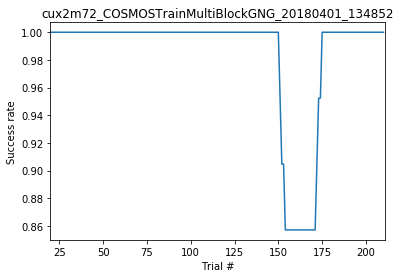

In [3]:
# Load data.
startt = time.time()

CT = CosmosTraces(dataset)
BD = CT.bd

print('Elapsed time: '+str(time.time() - startt))

In [5]:
BD.spout_lick_rates[0].shape

(211, 294)

In [4]:
# Setup some analysis specific variables.
smooth_spikes = gaussian_filter1d(CT.St, 1.5, axis=1, mode='constant')

# Define trial sets.
clean_trials = np.zeros(BD.success.shape)
clean_trials[BD.get_clean_trials(min_selectivity=0.95)] = 1

min_block_trial = 7
lick_spout1 = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                     BD.success, 
                                     BD.spout_positions==1,
                                     BD.ind_within_block>=min_block_trial,
                                     clean_trials))
lick_spout3 = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                     BD.success, 
                                     BD.spout_positions==3,
                                     BD.ind_within_block>=min_block_trial, 
                                     clean_trials))
lick_spout4 = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                     BD.success, 
                                     BD.spout_positions==4,
                                     BD.ind_within_block>=min_block_trial, 
                                     clean_trials))
nolick = np.logical_and.reduce((~BD.go_trials.astype('bool'), 
                                BD.success))


Detected 65 / 210 trials with lick selectivity >=  0.95


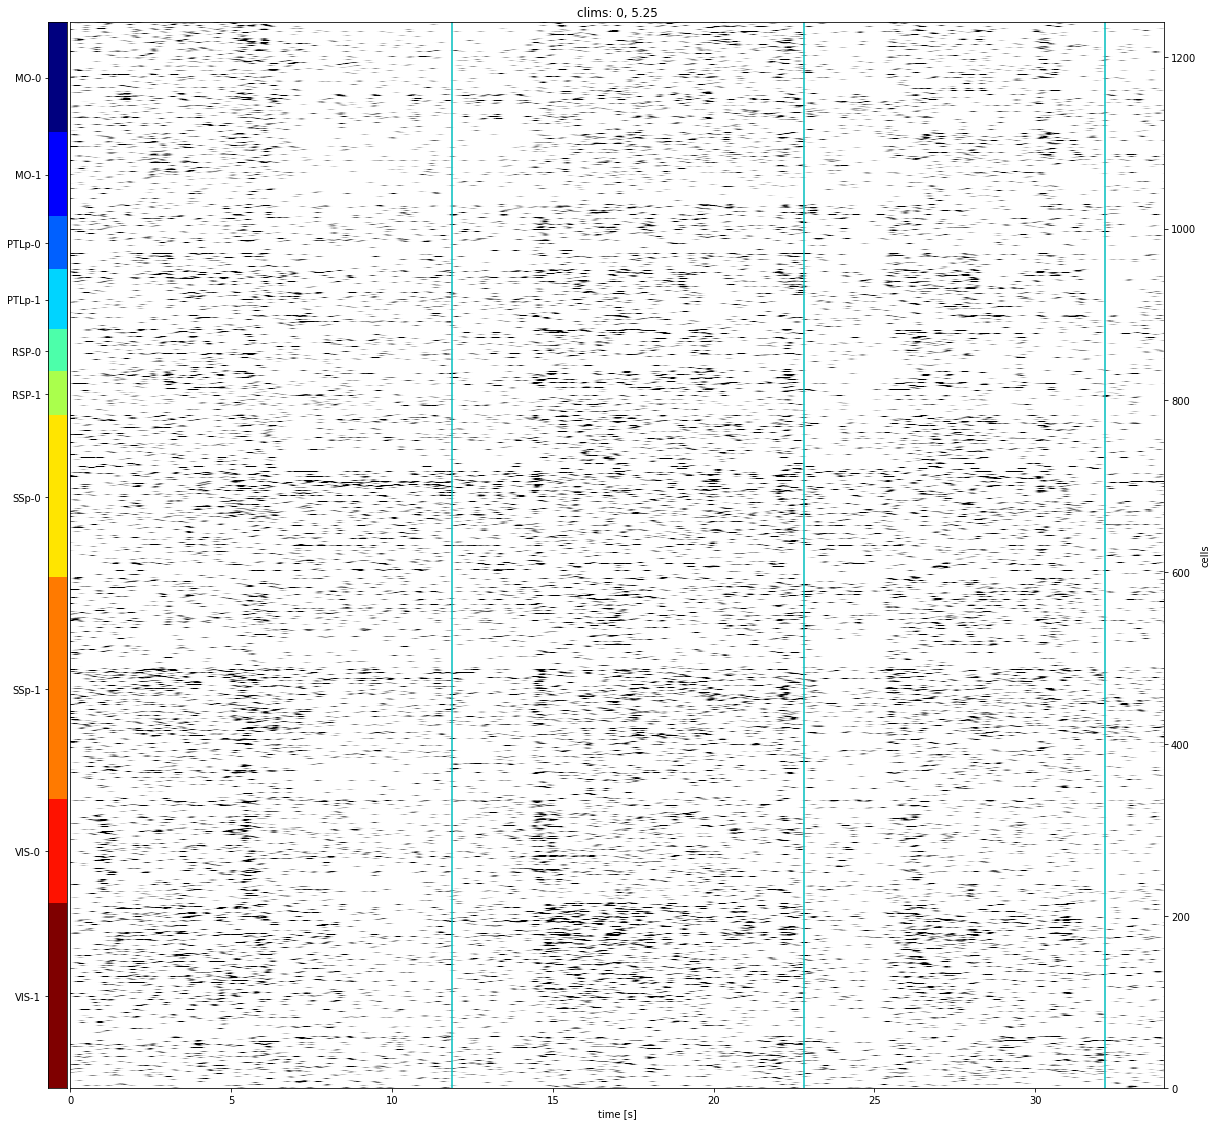

In [6]:
CT.plot_raster_by_region(traces=gaussian_filter1d(CT.S, 2, axis=1), startframe=0, nframes=1000, event_frames=CT.led_frames)

---Plotting contours: 1.845698356628418 seconds ---


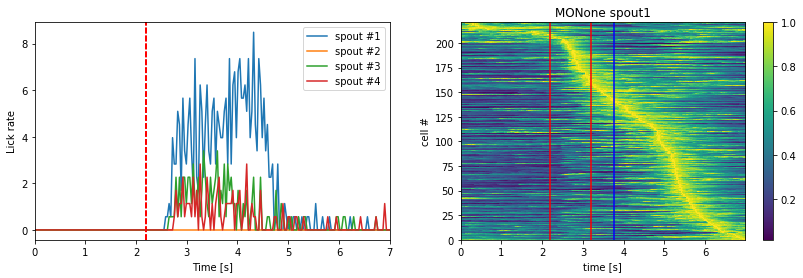

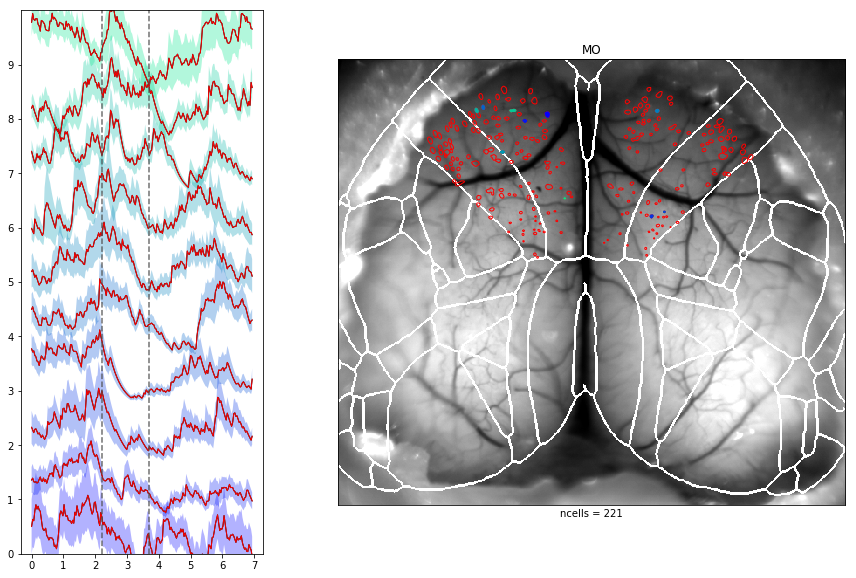

In [7]:
# Make general summary plots for specified cells and trials. 

# Select cells and regions.
region = 'MO' #'MO', 'SSp', 'PTLp', 'VIS', 'RSP'
hemisphere = None #0
spout_num = 1
which_cells = np.array(CT.cells_in_region[CT.regions[region]])
#which_cells = good_cells
if hemisphere is not None:
    which_cells = which_cells[np.where(CT.hemisphere_of_cell[which_cells]==hemisphere)[0]]

# which_cells = np.arange(np.shape(CT.Ct)[0])

lick_spout_trials = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                            BD.success, 
                                            BD.spout_positions==spout_num))

# Generate trial averages for specified trials and cells.
trials = lick_spout_trials
trials = trials[:CT.Ct.shape[2]]
traces = CT.Ct[which_cells,:,:][:,:,trials[:]]
footprints = CT.footprints[:,:,which_cells]
trial_means = np.mean(traces, axis=2)
trial_sems = scipy.stats.sem(traces, axis=2)


# Make plots.
plt.figure(figsize=(14,4))
BD.plot_mean_lick_rates(trials, ax=plt.subplot('121'))
plt.gca().set_xlim([0, 7])
ordering1 = utils.plot_average_trial_raster(trial_means, 
                                            bpod_data=CT.bd, 
                                            ordering='peak', 
                                            do_normalize=True, 
                                            dt = CT.dt,
                                            ax=plt.subplot('122'), 
                                            title=region+str(hemisphere)
                                                  +' spout'+str(spout_num))
ordering = CT.plot_variance_shaded_traces(trial_means, trial_sems, 
                                          cell_inds=np.arange(10, 20), # Set this
                                          footprints=footprints,
                                          ordering='peak', 
                                          title=region)                                       

MO
VIS
SSp


/home/izkula/src/COSMOS/cosmos/traces/trace_analysis_utils.py:678: RuntimeWarning: invalid value encountered in true_divide
  avgs = avgs/np.expand_dims(np.amax(avgs, axis=1),axis=1)


PTLp
RSP


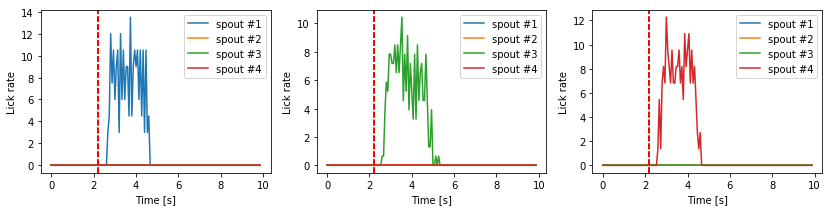

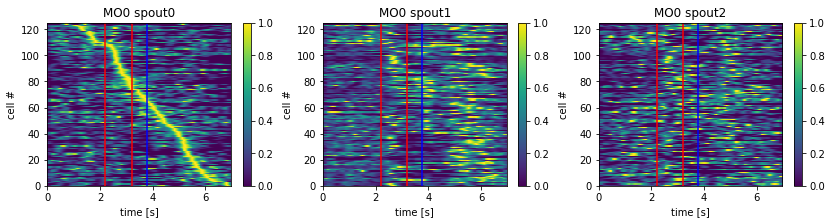

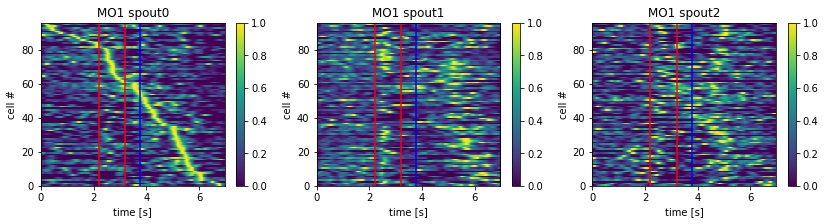

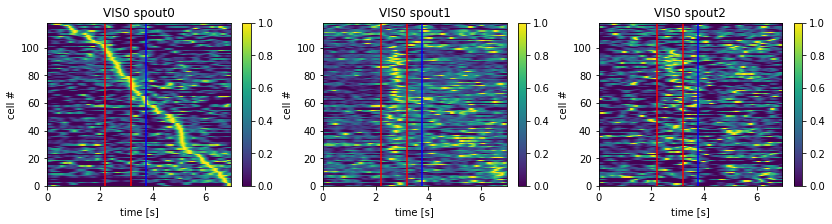

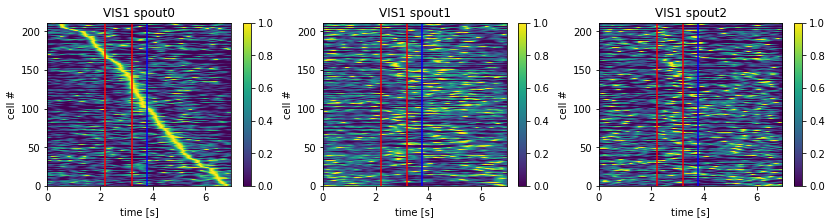

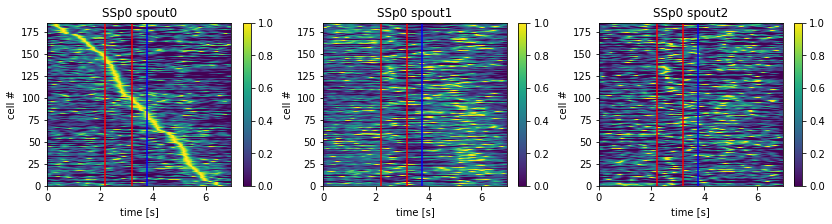

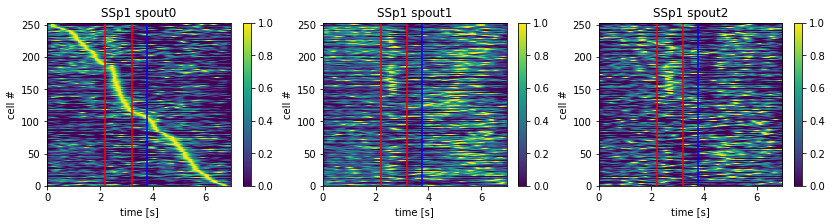

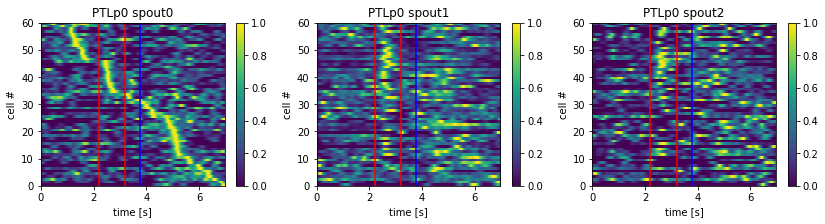

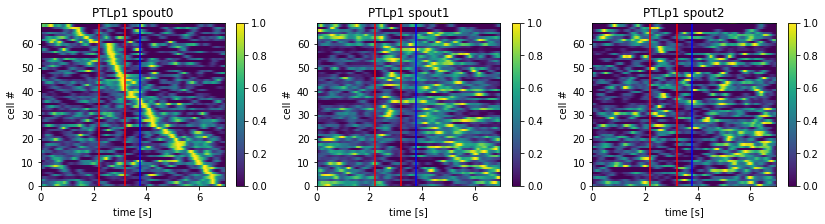

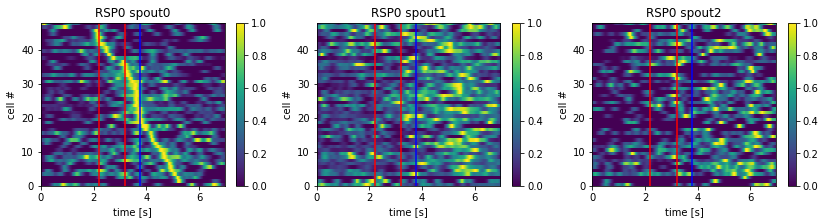

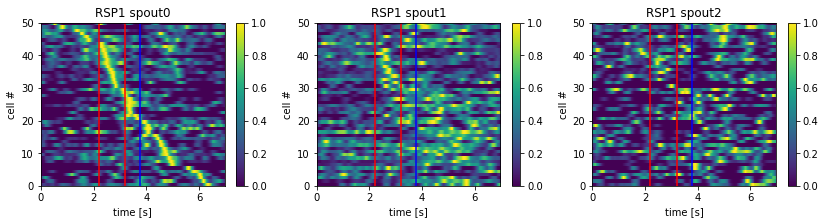

In [8]:
# Plot averaged rasters for each region, across each trial type
# Select cells and regions.

trial_sets = (lick_spout1, lick_spout3, lick_spout4)

plt.figure(figsize=(14,3))
BD.plot_mean_lick_rates(lick_spout1, ax=plt.subplot('131'))
BD.plot_mean_lick_rates(lick_spout3, ax=plt.subplot('132'))
BD.plot_mean_lick_rates(lick_spout4, ax=plt.subplot('133'))

# Generate trial averages for specified trials and cells.
for region in ['MO', 'VIS', 'SSp', 'PTLp', 'RSP']:
    print(region)
    for hemisphere in [0, 1]:
        which_cells = np.array(CT.cells_in_region[CT.regions[region]])
        #which_cells = good_cells
        if hemisphere is not None:
            which_cells = which_cells[np.where(CT.hemisphere_of_cell[which_cells]
                                               ==hemisphere)[0]]
        plt.figure(figsize=(14,3))
        for ind, trials in enumerate(trial_sets):
            traces = CT.St_smooth[which_cells,:,:][:,:,trials[:-1]]
            footprints = CT.footprints[:,:,which_cells]
            trial_means = np.mean(traces, axis=2)
            trial_sems = scipy.stats.sem(traces, axis=2)

            # Make plots.
            if ind == 0:
                ordering1 = utils.plot_average_trial_raster(trial_means, 
                                                        bpod_data=CT.bd, 
                                                        ordering='peak', 
                                                        do_normalize=True, 
                                                        dt = CT.dt,
                                                        ax=plt.subplot('13'+str(ind+1)), 
                                                        title=region+str(hemisphere)
                                                              +' spout'+str(ind))
            else:        
                utils.plot_average_trial_raster(trial_means, 
                                                bpod_data=CT.bd, 
                                                ordering=ordering1, 
                                                do_normalize=True, 
                                                dt = CT.dt,
                                                ax=plt.subplot('13'+str(ind+1)), 
                                                title=region+str(hemisphere)
                                                      +' spout'+str(ind))